# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

# Stock Return Prediction with Machine Learning Models

**Team Member**: Nicholas DeSanctis, Mingyi Yu, Jia Yi

**Table of contents**<a id='toc0_'></a>        
- [0 Introduction and Problem Statement](#toc2_1_)    
- [1 Load Data](#toc2_2_)    
- [2 Data Preprocessing](#toc2_3_)    
  - [Data Completeness](#toc2_3_1_)    
  - [Outlier Handling](#toc2_3_2_)    
  - [Response Variable](#toc2_3_3_)    
- [3 Preliminary EDA](#toc2_4_)    
  - [Response Variable Distribution](#toc2_4_1_)    
  - [Correlation Analysis](#toc2_4_2_)    
- [4 Feature Engineering](#toc2_5_)    
  - [Feature Construction](#toc2_5_1_)    
  - [Feature Visualization](#toc2_5_2_)    
  - [Feature Correlation](#toc2_5_3_)    
- [5 Model Pipelines](#toc2_6_)    
  - [Train Test Split](#toc2_6_1_)    
  - [Basic Linear Regression](#toc2_6_2_)    
  - [Random Forest Regressor](#toc2_6_3_)    
  - [Modeling with FFNNs](#toc2_6_4_)  
  - [Modeling with RNNs](#toc2_6_5_)  
- [6 Trading Strategy](#toc2_7_)    
- [7 Summary](#toc2_8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc2_1_'></a>[0 Introduction and Problem Statement](#toc0_)

Predicting stock returns is a critical task for investors, but traditional methods like fundamental and technical analysis require extensive domain knowledge and manual effort. In recent years, machine learning has emerged as a promising alternative for stock return prediction, capable of automatically learning and adapting to complex patterns in financial time series. With the vast amount of available data, including historical prices, financial reports, and news articles, machine learning algorithms can potentially improve the accuracy and efficiency of stock return predictions, enabling investors to make more informed decisions and enhance their investment strategies.

Our project aims to predict stock returns using various machine learning models including basic linear regression and neural networks. We use the S&P500 dataset obtained from Yahoo Finance, which contains data for 500 stocks over a period of 10 years. After conducting basic data processing and exploratory data analysis, we will generate useful features and build both basic and advanced deep learning models to fit the stock returns. We expect Neural Networks perform well given their ability to memorize past data.

Our project's unique contribution is the development of a simple trading strategy based on the model predictions. We will observe the performance of our trading strategy and compare it to the market's performance. Our goal is to demonstrate the potential of machine learning for stock return prediction and show how it can be applied in practice to enhance investors' decision-making.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
import seaborn as sns
from tqdm import trange
import time
import warnings
warnings.filterwarnings(action="ignore")

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew, kurtosis, spearmanr

## <a id='toc2_2_'></a>[1 Load Data](#toc0_)

We first load the csv which contains:
- **Date:** the trading day of the stock
- **Code:** the code of the stock
- **Open:** the open(first) price of the stock at that day
- **High:** the highest price of the stock at that day
- **Low:** the lowest price of the stock at that day
- **Close:** the close(last) price of the stock at that day
- **Adj Close:** adjusted close price that takes into account stock splits and dividends
- **Volume:** the volume of the stock being traded at that day
- **Return:** the investment return computed by: $r_i = (AdjClose_i - AdjClose_{i-1}) / AdjClose_{i-1}$

The reason that we use the Adj Close price to calculate investment return is that:
1. The high, low, open price are all very close to the close price so there is no need to use other prices.
2. Close price is at the end of day so it's convinient for us to compute the return across different days.
3. Adj Close included the effect of both close price and dividends so it represents the investment profits better.

In [2]:
data = pd.read_csv('../data/stock_data.csv')
data['Return'] = data['Return']*100 # scale Return by 100 so it is easy to understand in percent unit
data['Date'] = [d.date() for d in pd.to_datetime(data['Date'])] # convert Date from str to datetime
data

,Date,Code,Open,High,Low,Close,Adj Close,Volume,Return
0,2013-01-03,A,30.000000,30.143063,29.742489,30.064379,27.533512,5751791,0.358190
1,2013-01-03,AAL,14.020000,14.130000,13.600000,13.660000,12.877849,5398400,-2.288980
2,2013-01-03,AAP,72.849998,73.440002,72.129997,72.489998,67.488434,520600,0.000000
3,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.624590,352965200,-1.262249
4,2013-01-03,ABBV,35.000000,35.000000,34.160000,34.830002,22.915112,16739300,-0.825712
...,...,...,...,...,...,...,...,...,...
1187070,2023-03-27,XYL,99.470001,99.970001,98.800003,99.410004,99.410004,1307130,0.831735
1187071,2023-03-27,YUM,128.429993,128.789993,127.830002,128.289993,128.289993,1233180,0.359846
1187072,2023-03-27,ZBH,127.360001,127.820000,125.820000,126.000000,126.000000,768567,-0.031737
1187073,2023-03-27,ZBRA,290.869995,292.777496,285.930389,288.859985,288.859985,215756,0.045016


In [3]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Return
count,1.187075e+06,1.187075e+06,1.187075e+06,1.187075e+06,1.187075e+06,1.187075e+06,1.187075e+06
mean,1.138377e+02,1.151194e+02,1.125306e+02,1.138540e+02,1.070338e+02,5.374987e+06,6.606239e-02
std,1.963397e+02,1.988788e+02,1.938374e+02,1.964058e+02,1.963988e+02,1.536172e+07,1.977407e+00
min,7.000000e-01,7.100000e-01,6.500000e-01,7.000000e-01,7.000000e-01,0.000000e+00,-6.182730e+01
25%,4.337811e+01,4.384000e+01,4.290000e+01,4.339000e+01,3.784000e+01,9.668000e+05,-7.824386e-01
50%,7.268000e+01,7.343000e+01,7.193000e+01,7.270000e+01,6.451009e+01,2.026300e+06,7.969435e-02
75%,1.254500e+02,1.267913e+02,1.241200e+02,1.254900e+02,1.167167e+02,4.582200e+06,9.355517e-01
max,5.977610e+03,5.982450e+03,5.884060e+03,5.959330e+03,5.959330e+03,1.460852e+09,7.459324e+01


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187075 entries, 0 to 1187074
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date       1187075 non-null  object 
 1   Code       1187075 non-null  object 
 2   Open       1187075 non-null  float64
 3   High       1187075 non-null  float64
 4   Low        1187075 non-null  float64
 5   Close      1187075 non-null  float64
 6   Adj Close  1187075 non-null  float64
 7   Volume     1187075 non-null  int64  
 8   Return     1187075 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 81.5+ MB


## <a id='toc2_3_'></a>[2 Data Preprocessing](#toc0_)

### <a id='toc2_3_1_'></a>[Data Completeness](#toc0_)

We originally obtained 500 stocks but some of the data are missing for some stocks. We just dropped those stocks and there are still over 450 stocks left. These are the complete data we will use.

In [5]:
print(f'Number of days: {len(data.Date.unique())}')
print(f'Number of stocks: {len(data.Code.unique())}')
print(f'The data is complete: {len(data.Date.unique())} * {len(data.Code.unique())} = {len(data)}')

Number of days: 2575
Number of stocks: 461
The data is complete: 2575 * 461 = 1187075


### <a id='toc2_3_2_'></a>[Outlier Handling](#toc0_)

As can be seen in the `data.describe()`, there are some extreme large values in return (74.5%). Since `Return` is directly influencing the response variable (see below), we can use the 20%, a common boudary of `Return` to clip the outlier.

In [6]:
data['Return'] = np.clip(data['Return'], a_min=-20, a_max=20)

### <a id='toc2_3_3_'></a>[Response Variable](#toc0_)

We confirm the prediction target as **the Return in tomorrow**. We generate the response variable for separate stocks.

In [7]:
data_dict = {key: group for key, group in data.groupby('Code')}
for k in data_dict.keys():
    data_dict[k]['target'] = data_dict[k]['Return'].shift(-1)
    data_dict[k] = data_dict[k].dropna().reset_index(drop=True) 
# take a look
data_dict['AAPL']

,Date,Code,Open,High,Low,Close,Adj Close,Volume,Return,target
0,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.624590,352965200,-1.262249,-2.785394
1,2013-01-04,AAPL,19.177500,19.236786,18.779642,18.821428,16.161530,594333600,-2.785394,-0.588272
2,2013-01-07,AAPL,18.642857,18.903570,18.400000,18.710714,16.066456,484156400,-0.588272,0.269106
3,2013-01-08,AAPL,18.900356,18.996071,18.616072,18.761070,16.109692,458707200,0.269106,-1.562860
4,2013-01-09,AAPL,18.660713,18.750357,18.428213,18.467857,15.857920,407604400,-1.562860,1.239578
...,...,...,...,...,...,...,...,...,...,...
2569,2023-03-20,AAPL,155.070007,157.820007,154.149994,157.399994,157.399994,73641400,1.548383,1.194412
2570,2023-03-21,AAPL,157.320007,159.399994,156.539993,159.279999,159.279999,73938300,1.194412,-0.910345
2571,2023-03-22,AAPL,159.300003,162.139999,157.809998,157.830002,157.830002,75701800,-0.910345,0.696947
2572,2023-03-23,AAPL,158.830002,161.550003,157.679993,158.929993,158.929993,67622100,0.696947,0.830559


## <a id='toc2_4_'></a>[3 Preliminary EDA](#toc0_)

### <a id='toc2_4_1_'></a>[Response Variable Distribution](#toc0_)

We checked the distribution of the response variable and the it turns out to be close to Normal. This is a great result for us!

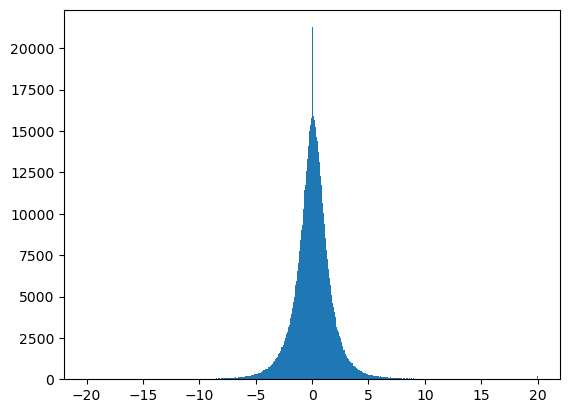

In [8]:
# all the data
plt.hist(pd.concat(data_dict.values())['target'], bins=1000)
plt.show()

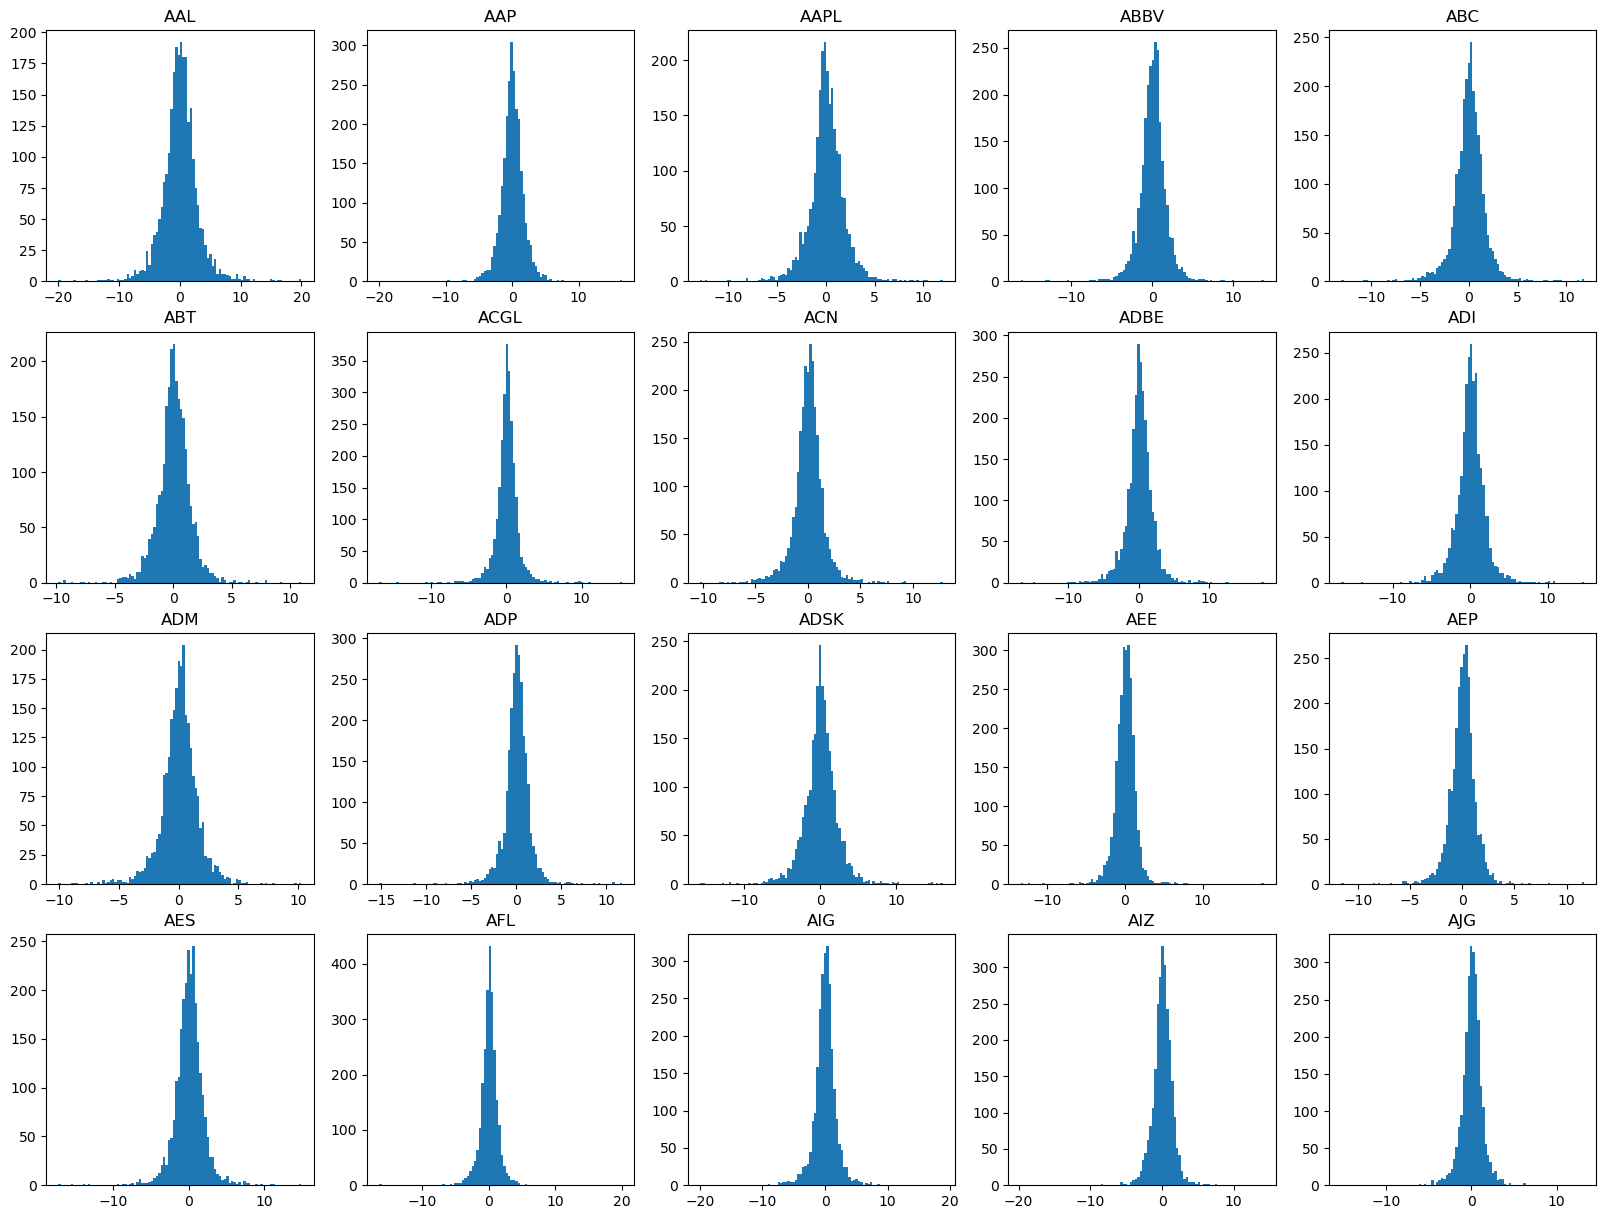

In [9]:
# divide into seperate stocks
plt.figure(figsize = (20, 15))
for k in range(1, 21):
    plt.subplot(4, 5, k)
    plt.hist(data_dict[list(data_dict.keys())[k]]['Return'], bins=100)
    plt.title(f'{list(data_dict.keys())[k]}')
plt.show()

We also used QQ plot to check the normality of `Return`.

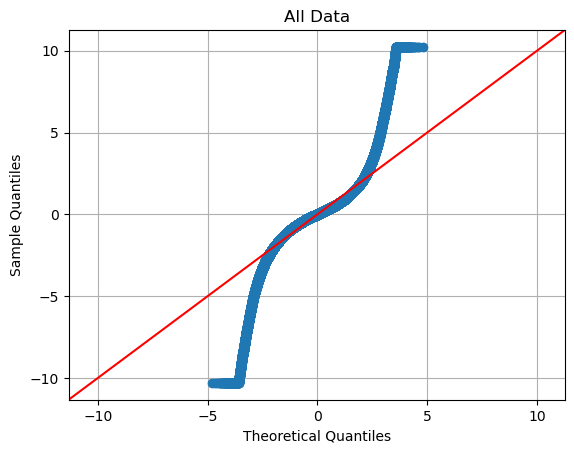

In [10]:
sm.qqplot(data['Return'], line='45', fit=True);
plt.grid()
plt.title('All Data')
plt.show()

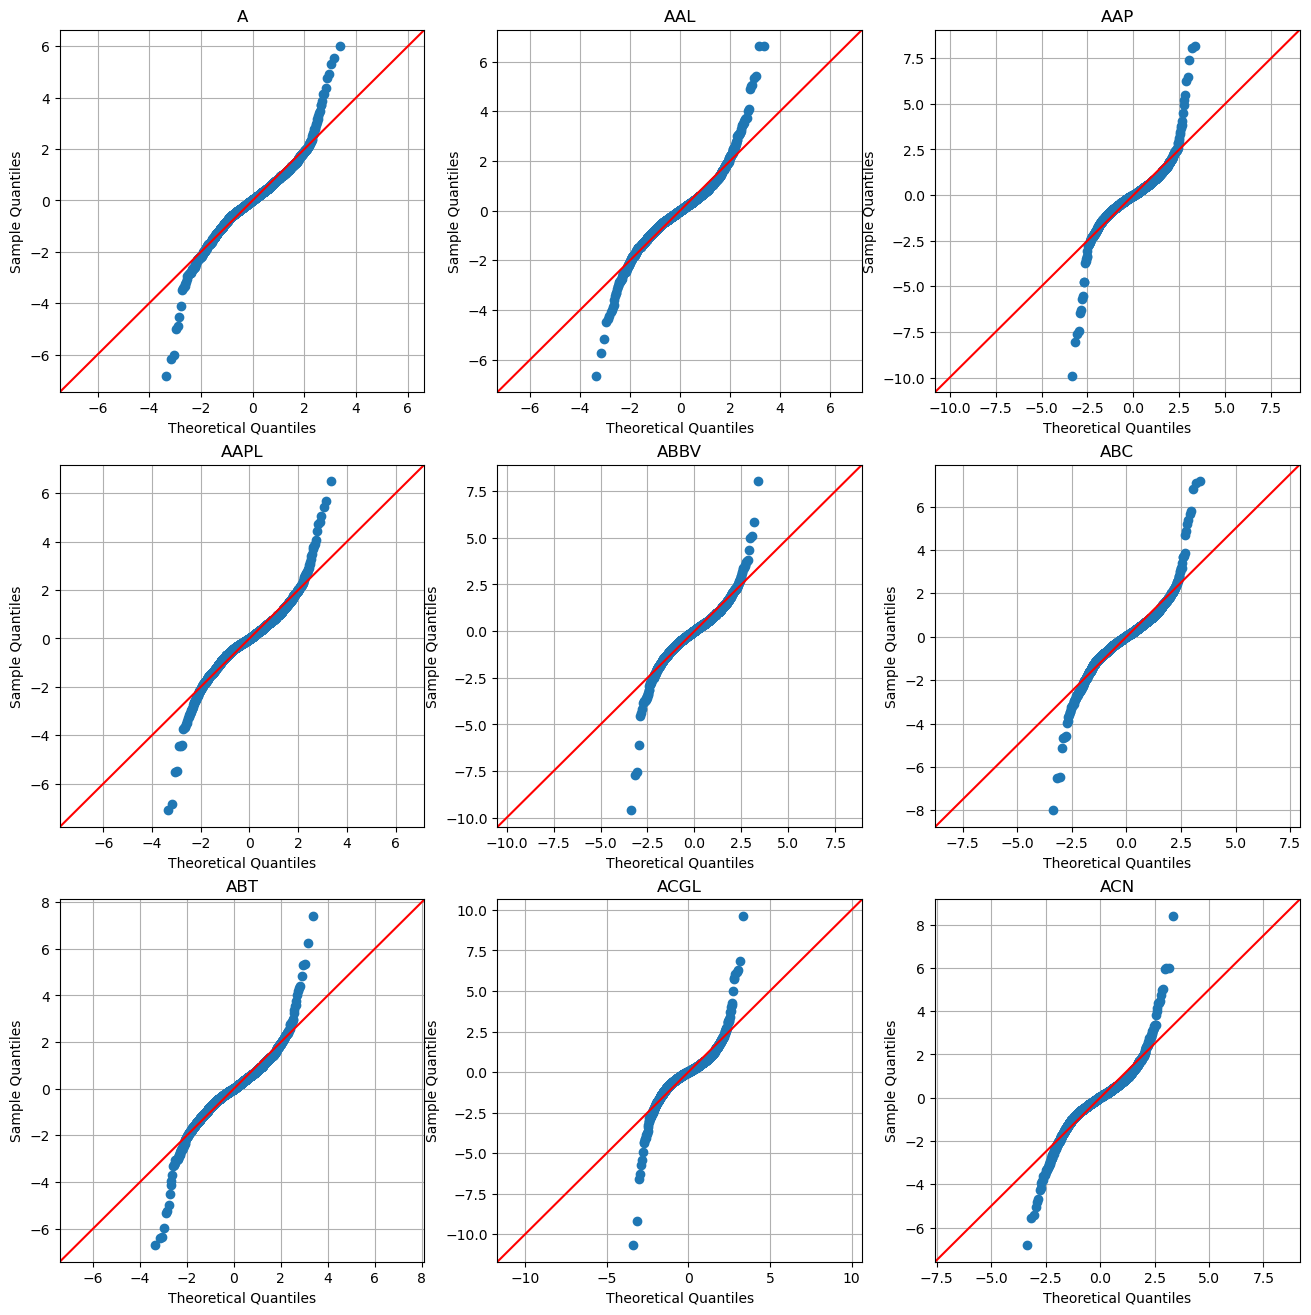

In [11]:
ret_list = [v.Return for v in data_dict.values()][:9]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))
for i, ret in enumerate(ret_list):
    sm.qqplot(ret, line='45', ax=axs[i//3, i%3], fit=True)
    axs[i//3, i%3].grid()
    axs[i//3, i%3].set_title(f"{list(data_dict.keys())[i]}")

We could see that compared to normal distribution, stock return have **a strong heavy tail**. The heavy-tailed distribution of a stock's return indicates that the stock is more volatile and has a higher potential for extreme events. When designing a prediction model for such a stock, it is important to consider the potential for extreme events and use methods that are robust to outliers or deep learning models (like RNNs) that can capture the nonlinearity and complexity of the data.

### <a id='toc2_4_2_'></a>[Correlation Analysis](#toc0_)

We’d like to see if there is any way that certain stock returns correlate heavily with each other. We can demonstrate this using a heatmap and the correlation feature of pandas. If there are highly correlated stocks, we can extract similar information from them and train them together.

In [12]:
# create dataframe of return values
df_ret = pd.concat([pd.Series(data_dict[code]['Return']).reset_index(drop=True).rename(code) for code in data_dict], axis=1)
df_ret.index = data_dict['AAPL']['Date']
df_ret.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.358190,-2.288980,0.000000,-1.262249,-0.825712,-0.206921,3.806572,-0.292923,-0.362025,-1.538863,...,0.000000,1.075628,-0.292167,-0.180352,-0.271475,-0.327295,0.625375,1.432821,0.097658,0.136399
2013-01-04,1.974765,7.833092,1.558800,-2.785394,-1.263305,0.668148,-0.601179,0.858759,0.552268,1.006625,...,0.823320,1.206648,0.366278,0.463008,0.866084,-0.145945,1.095010,0.509677,-0.804883,2.861032
2013-01-07,-0.723267,0.746782,-0.339592,-0.588272,0.203569,0.320478,0.816471,-0.985889,-0.433587,-0.498302,...,0.306221,0.339470,-1.058345,-1.157808,0.343507,-1.315253,-0.629423,0.246326,0.565536,-0.485658
2013-01-08,-0.799085,2.156317,-1.635489,0.269106,-2.176437,-0.136894,0.029981,0.135780,0.580642,0.527150,...,0.678446,-0.082544,0.184428,0.625523,-1.149140,-1.221824,-4.198012,0.144502,0.073347,-1.996460
2013-01-09,2.700791,-0.197875,0.304787,-1.562860,0.563615,0.000000,0.659674,0.361582,0.707172,1.363399,...,2.291081,0.355120,0.147267,-0.384327,-0.049467,1.574218,0.177737,1.847300,1.075003,-1.086441


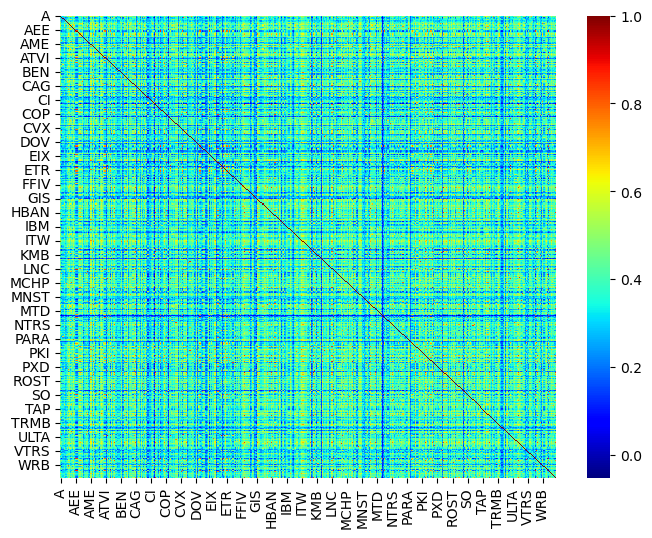

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(df_ret.corr(), cmap="jet");

There are just too many! Let's check the top20 correlated stocks.

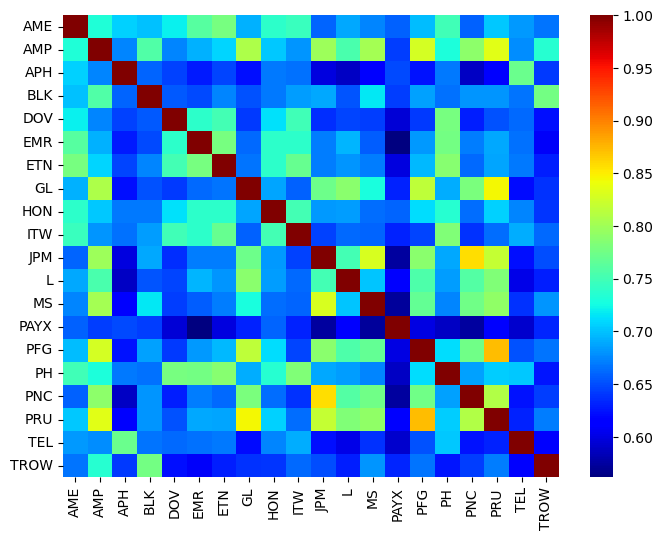

In [14]:
top20 = sorted(df_ret.corr().mean(axis=1).sort_values()[-20:].index)
plt.figure(figsize=(8,6))
sns.heatmap(df_ret[top20].corr(), cmap='jet');

Let's have a look of their Return series and feel the correlation. And we can see that the series are obviously correlated with each other.

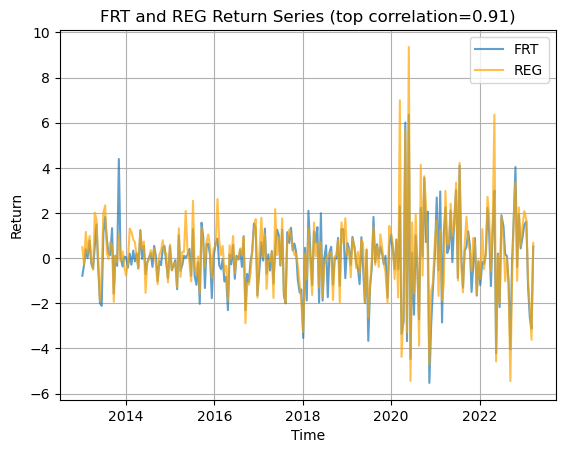

In [15]:
plt.plot(df_ret['FRT'][::10], label='FRT', alpha=0.7)
plt.plot(df_ret['REG'][::10], color='orange', alpha=0.7, label='REG')
plt.xlabel('Time')
plt.ylabel('Return')
temp = df_ret.corr().loc['FRT', 'REG']
plt.title(f'FRT and REG Return Series (top correlation={temp:.2f})')
plt.legend()
plt.grid()
plt.show()

Concluded from above, we can find that the correlation is very high on average (about 0.4~0.5). That is reasonale because they are all included in S&P500 and in the same U.S stock market. Therefore, training a bunch of stocks for one model is feasible.

## <a id='toc2_5_'></a>[4 Feature Engineering](#toc0_)

Now we have our `y`, it's time to determine our `X`. It is not reasonable to straightly use price and volume data -- stock market behavior is often nonlinear, meaning that a single price or volume data point may not fully capture the complex behavior of the market. We must construct our own features out of the price and volume data.

### <a id='toc2_5_1_'></a>[Feature Construction](#toc0_)

We construct several features for stock return prediction, which includes:
- Past return: sum of past return in 1, 5, 20 and 60 days.
- Volatility in past 5, 20 and 60 days, and average return divided by volatility.
- Inday return and fluctuation, as well as overnight return.
- Change of trading volume.
- Auto-correlation function (ACF)
- Skewness and Kurtosis of past 60 days.

In [16]:
def construct_features(df):
    
    # sum of past return
    df['ret_1'] = df['Return'].rolling(window = 1).sum()
    df['ret_5'] = df['Return'].rolling(window = 5).sum()
    df['ret_20'] = df['Return'].rolling(window = 20).sum()
    df['ret_60'] = df['Return'].rolling(window = 60).sum()
    
    # volatility
    df['vola_5'] = df['Return'].rolling(window=5).std()
    df['vola_20'] = df['Return'].rolling(window=20).std()
    df['vola_60'] = df['Return'].rolling(window=60).std()
    
    # ret/vola
    df['ret_vola_5'] = df['ret_5'] / (df['vola_5'] + 1e-5)
    df['ret_vola_20'] = df['ret_20'] / (df['vola_20'] + 1e-5)
    df['ret_vola_60'] = df['ret_60'] / (df['vola_60'] + 1e-5)
    
    # inday/overnight return and fluctuation
    df['inday_ret'] = np.clip((df['Close']/df['Open'] - 1)*100, -10, 10)
    df['inday_ret_5'] = df['inday_ret'].rolling(window = 5).sum()
    df['inday_fluc'] = np.clip((df['High']/df['Low'] - 1)*100, 0, 10)
    df['ov_ret'] = np.clip((df['Open']/df['Close'].shift(1) - 1)*100, -10, 10)
    
    # Volume change
    df['vol_change_5'] = np.clip(df['Volume'] / df['Volume'].rolling(window = 5).mean(), 0, np.sqrt(5))
    df['vol_change_20'] = np.clip(df['Volume'] / df['Volume'].rolling(window = 20).mean(), 0, np.sqrt(20))
    df['vol_change_60'] = np.clip(df['Volume'] / df['Volume'].rolling(window = 60).mean(), 0, np.sqrt(60))
    
    # ACF
    df['acf_1'] = df['Return'].rolling(window=60).apply(lambda x: acf(x)[1])
    df['acf_2'] = df['Return'].rolling(window=60).apply(lambda x: acf(x)[2])
    df['acf_3'] = df['Return'].rolling(window=60).apply(lambda x: acf(x)[3])
    
    # skewness and kurtosis
    df['skew'] = df['Return'].rolling(window = 60).apply(lambda x: skew(x))
    df['kurt'] = df['Return'].rolling(window = 60).apply(lambda x: kurtosis(x))
    
    return df

In [17]:
# construct features seperately
for i in trange(len(data_dict.keys())):
    k = list(data_dict.keys())[i]
    data_dict[k] = construct_features(data_dict[k])
# take a look
data_dict['AAPL'].head()

100%|██████████| 461/461 [07:22<00:00,  1.04it/s]


,Date,Code,Open,High,Low,Close,Adj Close,Volume,Return,target,...,inday_fluc,ov_ret,vol_change_5,vol_change_20,vol_change_60,acf_1,acf_2,acf_3,skew,kurt
0,2013-01-03,AAPL,19.567142,19.631071,19.321428,19.360714,16.624590,352965200,-1.262249,-2.785394,...,1.602587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-04,AAPL,19.177500,19.236786,18.779642,18.821428,16.161530,594333600,-2.785394,-0.588272,...,2.434252,-0.946319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-07,AAPL,18.642857,18.903570,18.400000,18.710714,16.066456,484156400,-0.588272,0.269106,...,2.736797,-0.948768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-08,AAPL,18.900356,18.996071,18.616072,18.761070,16.109692,458707200,0.269106,-1.562860,...,2.041242,1.013547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-09,AAPL,18.660713,18.750357,18.428213,18.467857,15.857920,407604400,-1.562860,1.239578,...,1.748100,-0.534922,0.886958,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That takes a long time! We shall save the results.

In [18]:
# merge all the data together and save
df_all = pd.concat(data_dict.values()).dropna().reset_index(drop=True)
df_all.to_csv('../data/df_all.csv', index=False)

In [3]:
# load from drive
df_all = pd.read_csv('../data/df_all.csv')
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all

,Date,Code,Open,High,Low,Close,Adj Close,Volume,Return,target,...,inday_fluc,ov_ret,vol_change_5,vol_change_20,vol_change_60,acf_1,acf_2,acf_3,skew,kurt
0,2013-04-01,A,29.921316,30.028612,29.177397,29.277538,26.889568,3552178,-2.477972,-0.659681,...,2.917379,-0.333573,0.950352,0.771702,0.744097,-0.136007,-0.066930,0.091142,-0.842011,2.233095
1,2013-04-02,A,29.413448,29.585121,29.034334,29.084406,26.712183,3291451,-0.659681,-0.344323,...,1.897019,0.464213,0.910793,0.715938,0.695455,-0.128722,-0.064330,0.089972,-0.803397,2.168939
2,2013-04-03,A,29.062946,29.320457,28.841202,28.984262,26.620207,7380042,-0.344323,2.196458,...,1.661705,-0.073784,1.682046,1.558121,1.554154,-0.119219,-0.045026,0.039949,-0.823108,2.387656
3,2013-04-04,A,28.998569,29.663805,28.998569,29.620888,27.204908,5478343,2.196458,0.313962,...,2.294029,0.049361,1.206422,1.141101,1.146080,-0.124581,-0.038301,-0.006706,-0.796821,2.181342
4,2013-04-05,A,29.134478,29.935621,29.091558,29.713877,27.290321,6932542,0.313962,0.288860,...,2.901401,-1.642119,1.301419,1.392412,1.435111,-0.098242,-0.033155,-0.011733,-0.840355,2.272215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158736,2023-03-20,ZION,30.850000,32.619999,29.799999,30.180000,30.180000,7680700,0.801602,6.991387,...,9.463086,3.039412,0.674316,1.308153,2.670887,-0.169926,0.368973,-0.226375,-1.278726,2.683671
1158737,2023-03-21,ZION,31.730000,33.080002,31.389999,32.290001,32.290001,9474400,6.991387,-6.720347,...,5.383888,5.135849,0.963449,1.509411,3.144865,-0.152636,0.249216,-0.149574,-0.980869,2.488011
1158738,2023-03-22,ZION,32.290001,33.040001,30.090000,30.120001,30.120001,7014400,-6.720347,-8.864542,...,9.803924,0.000000,0.748683,1.068853,2.260154,-0.226687,0.215217,-0.063870,-0.908873,1.934509
1158739,2023-03-23,ZION,30.389999,30.780001,27.000000,27.450001,27.450001,9700700,-8.864542,2.914387,...,10.000000,0.896410,1.075893,1.389543,2.990233,-0.120140,0.097464,-0.076637,-0.914045,1.485403


### <a id='toc2_5_2_'></a>[Feature Visualization](#toc0_)

Let's check the columns and pick our `X`s. And then we'd like to check the distribution of our features, just to have a sense of what they look like.

In [4]:
feature_list = df_all.columns[10:]
feature_list

Index(['ret_1', 'ret_5', 'ret_20', 'ret_60', 'vola_5', 'vola_20', 'vola_60',
       'ret_vola_5', 'ret_vola_20', 'ret_vola_60', 'inday_ret', 'inday_ret_5',
       'inday_fluc', 'ov_ret', 'vol_change_5', 'vol_change_20',
       'vol_change_60', 'acf_1', 'acf_2', 'acf_3', 'skew', 'kurt'],
      dtype='object')

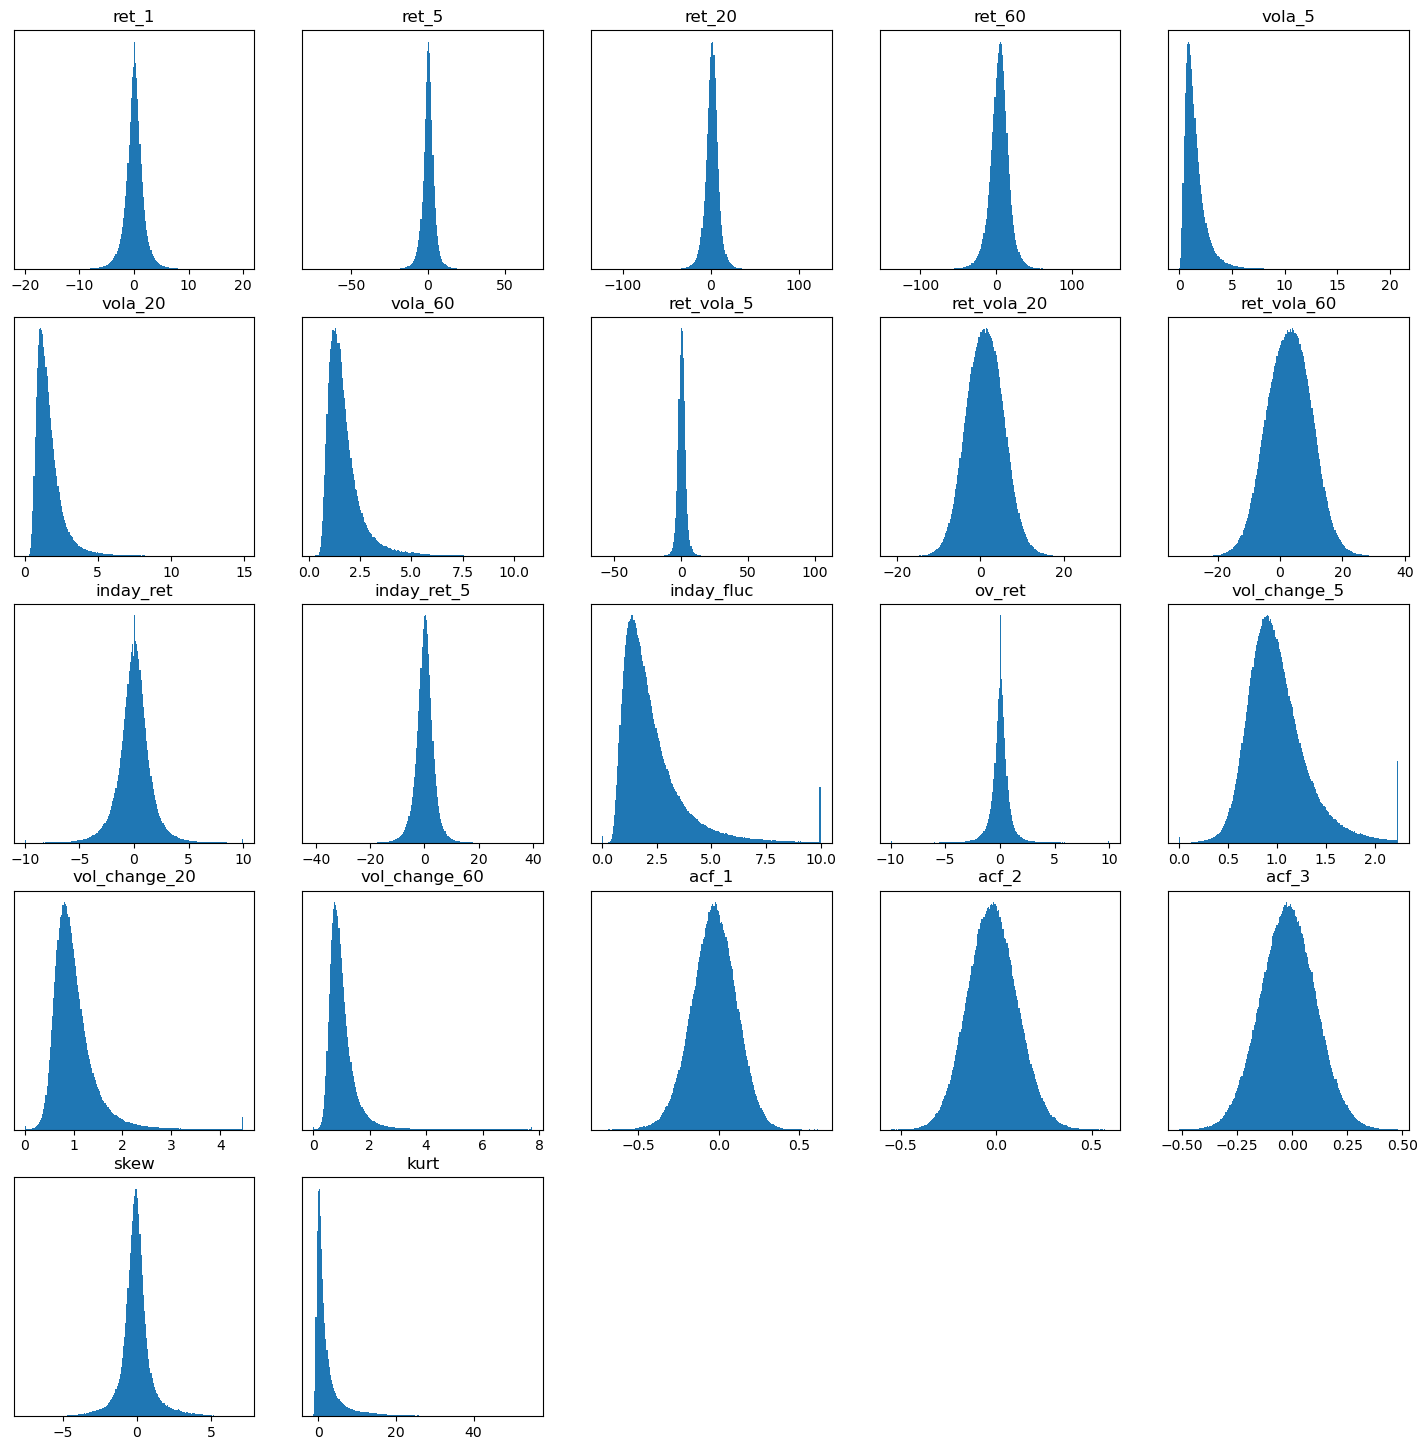

In [21]:
plt.figure(figsize = (18, 18))
for k in range(len(feature_list)):
    plt.subplot(5, 5, k+1)
    plt.yticks([])
    plt.title(feature_list[k])
    plt.hist(df_all[feature_list[k]], bins=200)

### <a id='toc2_5_3_'></a>[Feature Correlation](#toc0_)

How well are they related to the prediction target? We can use pearson correlation and spearman correlation to have a sense.

In [5]:
feature_corr = {}
for f in feature_list:
    feature_corr[f] = [None, None]
    feature_corr[f][0] = np.corrcoef(df_all[f], df_all['target'])[0, 1] # pearson corr
    feature_corr[f][1] = spearmanr(df_all[f], df_all['target'])[0] # spearman corr
pd.DataFrame(feature_corr, index=['Pearson Corr', 'Spearman Corr']).T

,Pearson Corr,Spearman Corr
ret_1,-0.026957,-0.023649
ret_5,-0.026404,-0.025061
ret_20,-0.018501,-0.018489
ret_60,-0.025026,-0.016348
vola_5,0.004621,0.011386
vola_20,0.025740,0.016325
vola_60,0.027557,0.011955
ret_vola_5,-0.020317,-0.026211
ret_vola_20,-0.014740,-0.020380
ret_vola_60,-0.019516,-0.018364


It doesn't behave so well (from the perspective of a quantitative finance researcher). However, the time for us to construct new, effective features is quite limited. We will move on with these and build up our models. We can try to generate other features when time is abundant and see whether it helps.

## <a id='toc2_6_'></a>[5 Model Pipelines](#toc0_)

### <a id='toc2_6_1_'></a>[Train Test Split](#toc0_)

We have our `X` and `y` now. How should we split the dataset? Splitting Test and Train for this will be slightly difficult, as the training data will overlap with itself, and we cannot use the future information to predict the past. We will save the data after 2021 for testing.

In [6]:
train = df_all[df_all['Date'] < pd.to_datetime('2021-01-01')]
test = df_all[df_all['Date'] >= pd.to_datetime('2021-01-01')]
X_train = train[feature_list]
y_train = train['target']
X_test = test[feature_list]
y_test = test['target']

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900594, 22)
(900594,)
(258147, 22)
(258147,)


### <a id='toc2_6_2_'></a>[Basic Linear Regression](#toc0_)

We'd like to use a basic model (almost the most basic model) to see if it's working and the performance. 

First we use statsmodel to analyze our fitting results, then we use the correlation between predicted value and actual value to evaluate the performance

In [8]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              288.9
Date:                Mon, 08 May 2023   Prob (F-statistic):                        0.00
Time:                        18:56:40   Log-Likelihood:                     -1.8131e+06
No. Observations:              900594   AIC:                                  3.626e+06
Df Residuals:                  900572   BIC:                                  3.626e+06
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ret_1             0.1349      0.008     17.592      0.000       0.120       0.150
ret_5          9.934e-06      0.001      0.009      0.993      -0.002       0.002
ret_20           -0.0042      0.001     -6.857      0.000      -0.005      -0.003
ret_60           -0.0067      0.000    -16.869      0.000      -0.007      -0.006
vola_5           -0.0863      0.003    -26.143      0.000      -0.093      -0.080
vola_20           0.0817      0.006     14.579      0.000       0.071       0.093
vola_60           0.0925      0.005     18.283      0.000       0.083       0.102
ret_vola_5        0.0019      0.001      1.779      0.075      -0.000       0.004
ret_vola_20       0.0035      0.001      3.411      0.001       0.001       0.005
ret_vola_60       0.0092      0.001     13.125      0.000       0.008       0.011
inday_ret        -0.1424      0.008    -18.872      0.000      -0.157      -0.128
inday_ret_5      -0.0146      0.001    -12.879      0.000      -0.017      -0.012
inday_fluc       -0.0097      0.002     -4.568      0.000      -0.014      -0.006
ov_ret           -0.1870      0.007    -25.491      0.000      -0.201      -0.173
vol_change_5     -0.1222      0.009    -13.323      0.000      -0.140      -0.104
vol_change_20     0.1191      0.014      8.601      0.000       0.092       0.146
vol_change_60    -0.0433      0.010     -4.356      0.000      -0.063      -0.024
acf_1             0.0102      0.014      0.733      0.463      -0.017       0.038
acf_2            -0.0115      0.015     -0.765      0.444      -0.041       0.018
acf_3             0.0606      0.015      3.964      0.000       0.031       0.091
skew              0.0120      0.002      5.554      0.000       0.008       0.016
kurt             -0.0047      0.001     -9.107      0.000      -0.006      -0.004
==============================================================================
Omnibus:                   121326.283   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1556046.563
Skew:                          -0.138   Prob(JB):                         0.00
Kurtosis:                       9.434   Cond. No.                         148.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
print(f"The corr between train set fitted values and real values = {np.corrcoef(model.fittedvalues, y_train)[0,1]:2f}")
print(f"The corr between test set fitted values and real values = {np.corrcoef(model.predict(X_test), y_test)[0,1]:2f}")

The corr between train set fitted values and real values = 0.074698
The corr between test set fitted values and real values = 0.028407


In [10]:
print(f'Variance on the training set: {pow(y_train, 2).mean()}')
print(f'Variance on the test set: {pow(y_test, 2).mean()}')

Variance on the training set: 3.3053403912628285
Variance on the test set: 4.140044878745022


We don't think it's a good fit -- the R-square is very low and the correlation of fitted values and real values is also small. But there is relationship indeed since the p-values of many features are almost zero. Maybe we can try to explore the non-linear relationship in them -- using our deep learning models.

### <a id='toc2_6_3_'></a>[Random Forest Regressor](#toc0_)

We also use a tree-based method - Random Forest Regressior for prediction.

In [28]:
%%time
model_rf = RandomForestRegressor(max_depth=5, min_samples_split=50, 
                                 min_samples_leaf=5, max_features=0.5, n_jobs=-1).fit(X_train, y_train)

CPU times: user 8min 27s, sys: 2.66 s, total: 8min 29s
Wall time: 1min 15s


In [29]:
print(f"The corr between train set fitted values and real values = {np.corrcoef(model_rf.predict(X_train), y_train)[0,1]:2f}")
print(f"The corr between test set fitted values and real values = {np.corrcoef(model_rf.predict(X_test), y_test)[0,1]:2f}")

The corr between train set fitted values and real values = 0.231345
The corr between test set fitted values and real values = 0.010697


From the results above, we think tree-based methods is not a good fit for our problem - tree based methods are easy to overfit especially when the number of features is small.

### <a id='toc2_6_4_'></a>[Modeling with FFNNs](#toc0_)


Some previous research has led us to believe that the best construction of a FFNN for stock prediction is one with only one or two dense layers, the introduction of a regularizer, and a dropout to reduce overfitting. The hyperparemeters in the model below were chosen after testing and running through different experiments. Overall, 2 layers with a sum total of several hundreds nodes typically yielded best results.

In [30]:
# Build model
model_fnn = tf.keras.models.Sequential(name='FFNN')
L2 = tf.keras.regularizers.L2(0.005)
model_fnn.add(tf.keras.layers.Dense(128,
                                    activation='relu',
                                    kernel_regularizer=L2,
                                    input_shape=(X_train.shape[1],),
                                    name='Input'))
model_fnn.add(tf.keras.layers.Dropout(0.5,
                                      name='Dropout1'))
model_fnn.add(tf.keras.layers.Dense(256,
                                    activation='relu',
                                    kernel_regularizer=L2,
                                    name='Dense1'))
model_fnn.add(tf.keras.layers.Dropout(0.5,
                                      name='Dropout2'))
model_fnn.add(tf.keras.layers.Dense(128,
                                    activation='relu',
                                    kernel_regularizer=L2,
                                    name='Dense2'))
model_fnn.add(tf.keras.layers.Dense(1,
                                    activation='linear',
                                    name='Output'))
model_fnn.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "FFNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 128)               2944      
                                                                 
 Dropout1 (Dropout)          (None, 128)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               33024     
                                                                 
 Dropout2 (Dropout)          (None, 256)               0         
                                                                 
 Dense2 (Dense)              (None, 128)               32896     
                                                                 
 Output (Dense)              (None, 1)                 129       
                                                   

2023-05-08 13:49:11.879459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-08 13:49:11.880013: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
plot_model(model_fnn, show_shapes=True)

In [31]:
model_fnn.compile(optimizer='adam', loss='mse')
history_fnn = model_fnn.fit(X_train, y_train,
                            validation_data=(X_test, y_test),
                            batch_size=1024,
                            epochs=100,
                            verbose=1,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)])

Epoch 1/100


2023-05-08 13:49:12.235445: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-08 13:49:12.402213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


880/880 [==============================] - ETA: 0s - loss: 4.6679

2023-05-08 13:49:17.541931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


880/880 [==============================] - 6s 6ms/step - loss: 4.6679 - val_loss: 4.6935
Epoch 2/100
880/880 [==============================] - 5s 6ms/step - loss: 3.8396 - val_loss: 4.4522
Epoch 3/100
880/880 [==============================] - 5s 6ms/step - loss: 3.6903 - val_loss: 4.3756
Epoch 4/100
880/880 [==============================] - 6s 6ms/step - loss: 3.6550 - val_loss: 4.3822
Epoch 5/100
880/880 [==============================] - 6s 6ms/step - loss: 3.6448 - val_loss: 4.3759
Epoch 5: early stopping


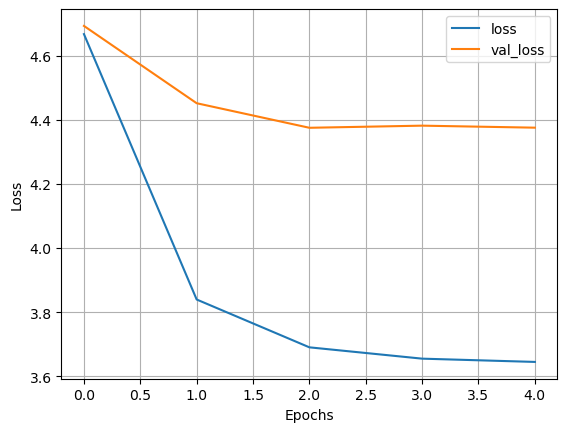

In [32]:
# Plot history
pd.DataFrame(history_fnn.history).plot(grid='on', xlabel='Epochs', ylabel='Loss');

In [33]:
print(f"The corr between train set fitted values and real values = {np.corrcoef(model_fnn.predict(X_train, verbose = -1).reshape(-1), y_train)[0,1]:2f}")
print(f"The corr between test set fitted values and real values = {np.corrcoef(model_fnn.predict(X_test, verbose = -1).reshape(-1), y_test)[0,1]:2f}")

2023-05-08 13:49:40.258806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


The corr between train set fitted values and real values = 0.216873
The corr between test set fitted values and real values = 0.034327


In [34]:
# Evaluation
print(f"RMSE on Test Set = {np.sqrt(model_fnn.evaluate(X_test, y_test, verbose=0)):2f}")

RMSE on Test Set = 2.091867


Although the performance is better than linear regression, the results still seems not so well. However, in finance, it's extremely difficult to predict asset return in the future according to the efficient market hypothesis (EMH). So we will construct a trading strategy to evaluate our prediction based on the performance of our asset.

### <a id='toc2_6_5_'></a>[Modeling with RNNs](#toc0_)

Our first idea is the use a basic LSTM model with bidrectional layers that feeds into a GRU gate with a sufficient amount of nodes to see how an RNN can fare. However, before doing that, we need to structure the data into a series that the RNN can read from left to right and right to left.

"ttt", or "train-test-split" is a custom function we created. It specifies the stocks that we want to predict on, how many days we want to feed in at a time, and whether or not we want the stocks as distinct sequences, or we want to feed it by date.

In [11]:
def ttt(stocks, days=60):
    '''
    returns train_test split of stocks
    '''
    dfs = [train[train['Code'] == stock].sort_values('Date') for stock in stocks]
    x_train = np.zeros((sum([len(df) - 100 for df in dfs]), \
                        len(feature_list), days))
    y_train = np.zeros(sum([len(df) - 100 for df in dfs]))
    x_test = np.zeros((100 * len(stocks), len(feature_list), days))
    y_test = np.zeros(100 * len(stocks))
    for df in dfs:
        counter = 0
        for i, day in enumerate(range(days, len(df) - 100)):
            try:
                x_train[counter, :, :] = df[feature_list].iloc[day - days: day].transpose()
                y_train[counter] = df['target'].iloc[day]
                counter += 1
            except:
                print('Error occured')
                print(f'Counter: {counter}')
                print('DF: {0}'.format(df['Code']))
                return 1, 2, 3, 4
        counter = 0
        for i, day in enumerate(range(len(df) - 100, len(df))):
            x_test[counter, :, :] = df[feature_list].iloc[day - days: day].transpose()
            y_test[counter] = df['target'].iloc[day]
            counter += 1

    return np.array(x_train).astype('float64'), \
        np.array(y_train).astype('float64'), \
            np.array(x_test).astype('float64'), \
                np.array(y_test).astype('float64')

In [12]:
X_train_tmp, y_train_tmp, X_test_rnn, y_test_rnn = ttt(train['Code'].unique()[:20])
X_train_rnn, X_val_rnn, y_train_rnn, y_val_rnn = train_test_split(X_train_tmp, y_train_tmp, test_size=0.1)
print(X_train_rnn.shape)
print(X_val_rnn.shape)
print(X_test_rnn.shape)

(33390, 22, 60)
(3710, 22, 60)
(2000, 22, 60)


In [13]:
# Build model
model_rnn = tf.keras.models.Sequential(name='RNN')
model_rnn.add(tf.keras.layers.Input(shape=X_train_rnn[0].shape,
                                    name='Input'))
model_rnn.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True,),
                                            name='BiLSTM'))
model_rnn.add(tf.keras.layers.GRU(300,
                                  name='GRU'))
model_rnn.add(tf.keras.layers.Dense(1,
                                    activation='linear',
                                    name='Output'))
model_rnn.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 BiLSTM (Bidirectional)      (None, 22, 600)           866400    
                                                                 
 GRU (GRU)                   (None, 300)               811800    
                                                                 
 Output (Dense)              (None, 1)                 301       
                                                                 
Total params: 1,678,501
Trainable params: 1,678,501
Non-trainable params: 0
_________________________________________________________________


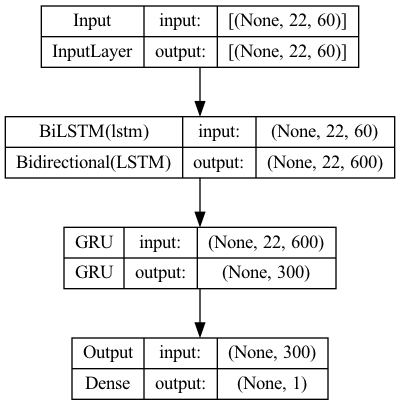

In [14]:
plot_model(model_rnn, show_shapes=True)

For good results, we take 20 out of the 461 stocks to train on. Training on all 461 causes predictions to shrink to 0, and one stock alone is not enough data to train on.

In [15]:
# Compile and train
model_rnn.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_rnn = model_rnn.fit(X_train_rnn, y_train_rnn,
                            validation_data=(X_val_rnn, y_val_rnn),
                            batch_size=64,
                            epochs=10,
                            verbose=1,
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)])

Epoch 1/10


2023-05-08 18:58:27.190745: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


522/522 [==============================] - 65s 120ms/step - loss: 0.1245 - root_mean_squared_error: 0.3528 - val_loss: 0.0919 - val_root_mean_squared_error: 0.3031
Epoch 2/10
522/522 [==============================] - 62s 118ms/step - loss: 0.1220 - root_mean_squared_error: 0.3493 - val_loss: 0.0864 - val_root_mean_squared_error: 0.2940
Epoch 3/10
522/522 [==============================] - 63s 121ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.0917 - val_root_mean_squared_error: 0.3028
Epoch 4/10
522/522 [==============================] - 62s 119ms/step - loss: 0.1133 - root_mean_squared_error: 0.3366 - val_loss: 0.1458 - val_root_mean_squared_error: 0.3818
Epoch 5/10
522/522 [==============================] - 64s 122ms/step - loss: 0.1062 - root_mean_squared_error: 0.3259 - val_loss: 0.0983 - val_root_mean_squared_error: 0.3136
Epoch 5: early stopping


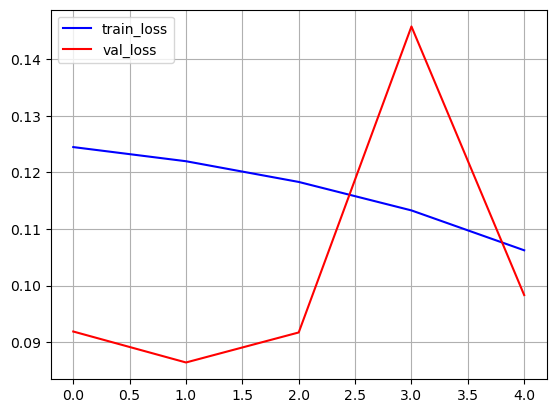

In [16]:
# Plot history
plt.plot(range(len(history_rnn.history['loss'])), history_rnn.history['loss'], color='b', label='train_loss')
plt.plot(range(len(history_rnn.history['val_loss'])), history_rnn.history['val_loss'], color='r', label='val_loss')
plt.legend()
plt.grid()
plt.show()

In [21]:
print(f"RMSE on Test Set = {np.sqrt(model_rnn.evaluate(X_test_rnn, y_test_rnn, verbose=0)[0]):2f}")

RMSE on Test Set = 0.332532


Because of how intricate RNNs are and how much processing needs to go into preparation, we continue our trading strategy using FFNNs in comparison to Linear Regression for simplicity.

## <a id='toc2_7_'></a>[6. Trading Strategy](#toc0_)

In the last part of our project, we construct a simple trading strategy to examine the performance of our prediction. 

The two trading strategy we construct is as follows:
1. Baseline strategy: we allocate our assets to all stocks evenly, which could be viewed as market return and served as our baseline strategy
2. Strategy with prediction: for each date, we allocate our aseets to 50 stocks with highest predicted return in the next date evenly, and compare the performance with our baseline model.

From the results below, we could see that both linear regression and fully-connected neural networks could perform better than market return, and neural networks behave much better. This means that our prediction model could capture some features of the actual stock return and outperform market significantly.

In [35]:
def cal_avg_return(df):
    target = df['target']
    return target.mean()

def cal_strat_return(df, model):
    features = df[feature_list]
    target = df['target']
    predictions = model.predict(features)
    return target[predictions.nlargest(50).index].mean()

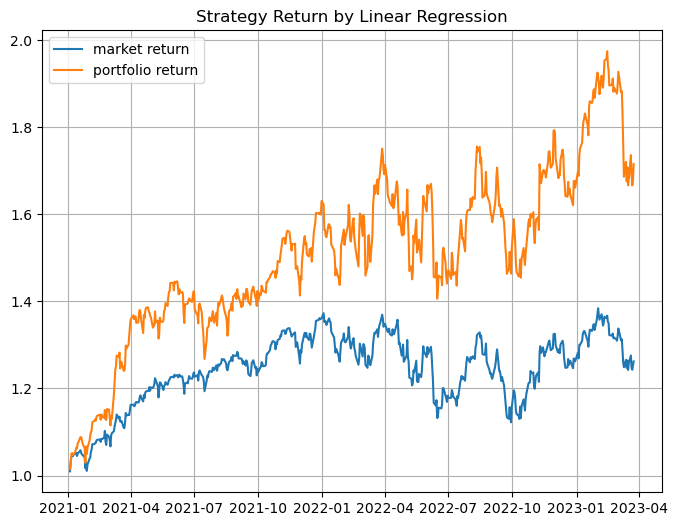

In [36]:
plt.figure(figsize = (8, 6))
market_return = test.groupby('Date').apply(cal_avg_return)
strategy_return = test.groupby('Date').apply(cal_strat_return, model)

plt.plot(np.exp(market_return.cumsum()/100), label = 'market return')
plt.plot(np.exp(strategy_return.cumsum()/100), label = 'portfolio return')
plt.title('Strategy Return by Linear Regression')
plt.legend()
plt.grid()
plt.show()

In [37]:
def cal_strat_return(df, model):
    features = df[feature_list]
    target = df['target']
    predictions = model_fnn.predict(features, verbose = 0).reshape(-1)
    largest_indices = np.argsort(predictions)[-50:]
    return target.iloc[largest_indices].mean()

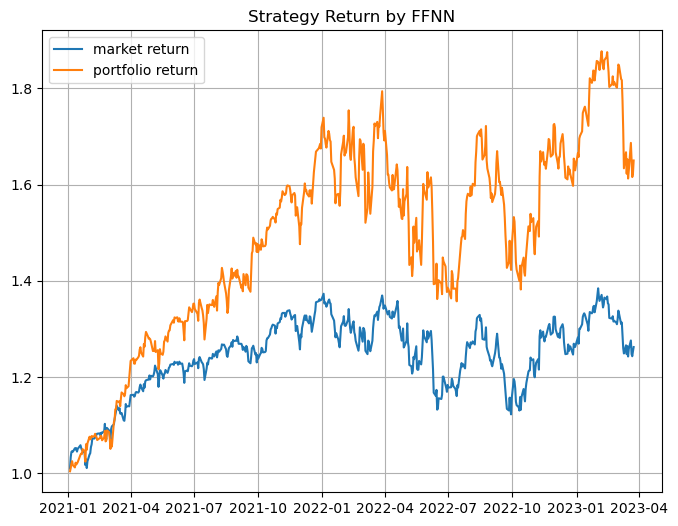

In [38]:
plt.figure(figsize = (8, 6))
market_return = test.groupby('Date').apply(cal_avg_return)
strategy_return = test.groupby('Date').apply(cal_strat_return, model_fnn)

plt.plot(np.exp(market_return.cumsum()/100), label = 'market return')
plt.plot(np.exp(strategy_return.cumsum()/100), label = 'portfolio return')
plt.title('Strategy Return by FFNN')
plt.legend()
plt.grid()
plt.show()

## <a id='toc2_8_'></a>[7. Summary](#toc0_)

In our project, we use machine learning methods to predict stock return in S&P500 stocks. Firstly we do data preprocessing and exploratory data analysis (EDA) including analyzing the return distribution and the correlation between different stocks. Then we construct several useful features based on past information which could be useful for prediction. After that, we use several machine learning models including linear regression, random forest and neural networks to predict stock return in the next day. Finally, we construct a simple trading strategy and show that our model could perform non-trivial stock return prediction.